In [3]:
# import libraries
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from PIL import Image
import pandas as pd
weatherclimateED = pd.read_csv("weatherclimateED.csv", parse_dates = [0], dayfirst = True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
import statsmodels.api as sm
from pycirclize import Circos
from scipy.stats import gaussian_kde
from joblib import Parallel, delayed
import os
import itertools
import patchworklib as pw 

import warnings

os.environ["PYTHONWARNINGS"] = "ignore" # this change is only for this time's session

In [4]:
from epiweeks import Week, Year
from datetime import date
def create_epiweek(date):
    return Week.fromdate(date)
def create_epiweekplot(epiweek):
    epiweek = str(epiweek)
    return F'Y{epiweek[:4]}W{epiweek[4:]}'
def create_epiweek_fromstr(str):
    return Week.fromstring(str)
def create_epiweek_fromint(int):
    return Week.fromstring(str(int))

In [5]:
# def find_min_model(lag, step, target_var, error_metric_directory, error_metric):
#     error_file_path = os.path.join(target_var, error_metric_directory, F'L{lag}_S{step}.csv')
#     if os.path.isfile(error_file_path):
#         error_df = pd.read_csv(error_file_path)
#         min_val = error_df[error_metric].min()*100
#         min_model = error_df.iloc[error_df[error_metric].idxmin(), 0]
#     else:
#         min_val = 0
#         min_model = 'N/A'
#     return min_val, min_model

In [6]:
# def find_min_max(circos_df, step_list):
#     min_max = pd.DataFrame()
#     for step in step_list:
#         min_max.at[F'step{step}', 'min'] = circos_df[step]['min_val'].min()
#         min_max.at[F'step{step}', 'max'] = circos_df[step]['min_val'].max()
#     return min_max

# min_max = find_min_max(circos_df, [1,2,3,4,5,6,7,8,9,10,11,12])
# min_max['max'].max()

# min_max['min'].min()

In [7]:
# To change the name of models in the labels of the plots
# normal models are simple models, combinations
normal_model = {}

normal_model['naive'] = 'Naive'
normal_model['historymean'] = 'HM'
normal_model['ar_pure'] = 'AR(A)'
normal_model['ar_env'] = 'AR(B)'
normal_model['ridge'] = 'Ridge'
normal_model['lasso'] = 'LASSO'
normal_model['alasso'] = 'ALASSO'
normal_model['sgl'] = 'SGL'
normal_model['elasticnet'] = 'ENET'
normal_model['purefactor'] = 'PF'
normal_model['knn'] = 'KNN'
normal_model['xgboost'] = 'XGBoost'
normal_model['linearpool_P1'] = 'linear pool (P1)'
normal_model['linearpool_P2'] = 'linear pool (P2)'
normal_model['linearpool_P3'] = 'linear pool (P3)'
normal_model['harmonicpool_P1'] = 'harmonic pool (P1)'
normal_model['harmonicpool_P2'] = 'harmonic pool (P2)'
normal_model['harmonicpool_P3'] = 'harmonic pool (P3)'
normal_model['logpool_P1'] = 'log pool (P1)'
normal_model['logpool_P2'] = 'log pool (P2)'
normal_model['logpool_P3'] = 'log pool (P3)'
normal_model['vincentization_P1'] = 'vincentization (P1)'
normal_model['vincentization_P2'] = 'vincentization (P2)'
normal_model['vincentization_P3'] = 'vincentization (P3)'


# For subsequent traversals
all_models = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ridge', 'lasso', 'alasso', 'sgl',
                 'elasticnet', 'purefactor', 'knn', 'xgboost']
all_combinations = ['linearpool_P1', 'linearpool_P2', 'linearpool_P3', 'harmonicpool_P1', 'harmonicpool_P2', 'harmonicpool_P3',
                   'logpool_P1', 'logpool_P2', 'logpool_P3', 'vincentization_P1', 'vincentization_P2', 'vincentization_P3'] 

## ploting the time series of actual and forecasts

In [34]:
def single_plot(pred, lag, step, target_var, model, output_directory): # for density forecast submodels and combi density forecast
    output_directory_path = os.path.join(output_directory, target_var)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    output_file = os.path.join(output_directory_path, F'{model} {step}-week.pdf')
    
    y_pred = pred.copy()
    fig, ax1 = plt.subplots(1,1, figsize=(16,6))
    # Set the x-axis limits
    plt.xlim([0,len(pred)])

    # Shade the training dataset
    epiweek_values = list(y_pred.index.values)
    first_valid_index = epiweek_values.index(y_pred['0'].first_valid_index()) # becasue the length of columns '0'-'999' is different from column target_var
    plt.axvspan(0, first_valid_index, facecolor='#d9d9d9', alpha=0.5)
    

    
    # Plot the polygon
    percentiles = np.linspace(0, 100, 101)
    cmap = cm.get_cmap('Greens')

    add_lable = True
    for p in reversed(percentiles):
        if p >= 100-p:
            upper_bound = []
            lower_bound = []
            for index, row in y_pred.iterrows():
                upper_bound.append(np.percentile(np.array(row[1:-1]), p))
                lower_bound.append(np.percentile(np.array(row[1:-1]), 100 - p))
            color_intensity = 1 - (p - 50) / 50  # Closer to 50% is darker
            color = cmap(color_intensity)
            ax1.fill_between(y_pred['epiweekplot'], lower_bound, upper_bound, color=color, alpha=1, label='   Percentile' if add_lable else None)
            add_lable = False
    
    # Plot the line
    ax1.plot(y_pred['epiweekplot'][:first_valid_index+1], y_pred[target_var][:first_valid_index+1], label='   Actual in train set', linestyle='-', linewidth=1.2, alpha=1, color='black')
    ax1.plot(y_pred['epiweekplot'][first_valid_index:], y_pred[target_var][first_valid_index:], label='   Actual in forecast set', linestyle='-', linewidth=1.2, alpha=1, color='#CC0000')
    
    # Plot settings
    ax1.set_xticks(y_pred['epiweekplot'][::52])
    ax1.set_xticklabels("")
    
    ax1.set_xticks(y_pred['epiweekplot'][26::52], minor=True)
    start_range = int(y_pred['epiweekplot'][0][1:5])
    end_range = int(y_pred['epiweekplot'][-1][1:5])+1
    ax1.set_xticklabels(range(start_range,end_range), minor=True)

    ax1.tick_params(axis='x', which='minor', length=0, width=0, pad=7.5, labelsize=18)
    ax1.tick_params(axis='y', which='major', length=5, width=1, pad=7.5, labelsize=18)

    plt.title(F'{target_var} {step}-week ahead {normal_model[model]} forecast', fontsize=18)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('ED Admissions', fontsize=18)




    # Add color bars
    reversed_cmap = cmap.reversed()
    colors = cmap(np.linspace(0, 1, 100))  # First half (0-50)
    colors_reversed = reversed_cmap(np.linspace(0, 1, 128))  # Second half (50-100)
    symmetric_colors = np.vstack((colors, colors_reversed))  # Stack them vertically
    symmetric_cmap = LinearSegmentedColormap.from_list("symmetric_Greens", symmetric_colors)

    norm = Normalize(vmin=0, vmax=100)
    sm = ScalarMappable(cmap=symmetric_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, shrink=0.08, aspect=1.3)
    cbar.ax.tick_params(labelsize=7)
    cbar.ax.set_position([0.139, 0.77, 0.02, 0.09])
    cbar.set_ticks([0, 50, 100])
    cbar.set_ticklabels(['0%', '50%', '100%'])

    
    plt.legend(loc='upper left', fontsize=18)
    plt.savefig(output_file)
#     plt.show()

def data_setup(lag, step, target_var, model):
    if model in all_models:
        y_pred = pd.read_csv(F'{target_var}/pred/L{lag}_S{step}/{model}.csv', parse_dates = [0], dayfirst = True)
    else:
        y_pred = pd.read_csv(F'{target_var}/combi_samples/L{lag}_S{step}/{model}.csv', parse_dates = [0], dayfirst = True)

    y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
    y_pred = y_pred.set_index('epiweek')
    y_pred = y_pred.drop(target_var, axis=1)


    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_pred_full = pd.concat([y_full, y_pred], axis=1)
    y_pred_full['epiweekplot'] = y_pred_full.index
    y_pred_full['epiweekplot'] = y_pred_full['epiweekplot'].apply(create_epiweekplot)

    return y_pred_full

def plot_individual(lag, step, target_var, model, output_directory):
    y_pred = data_setup(lag, step, target_var, model)
    single_plot(y_pred, lag, step, target_var, model, output_directory)




def plot_disease(lag, step, target_variables_file, model, output_directory):
    target_variables = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            target_variables.append(target_variable)
    print(target_variables)
    for disease in target_variables:
        plot_individual(lag, step, disease, model, output_directory)


# for step in range(1, 13):
#     for model in all_models + all_combinations:
#         plot_disease(8, step, 'target_variables_new.txt', model, 'epiweekplot')

combinations = list(itertools.product(range(1, 13), all_models + all_combinations))
Parallel(n_jobs=-1, verbose=51)(delayed(plot_disease)(8, step, 'target_variables_new.txt', model, 'epiweekplot') for step, model in combinations)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 47.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 84.9min
[Parallel(n_jobs=-1)]: Done 271 out of 288 | elapsed: 87.4min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done 277 out of 288 | elapsed: 88.7min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done 283 out of 288 | elapsed: 90.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 91.4min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrin

## plot metrics by disease

In [19]:
def create_error_df(target_var, error_metric_directory, error_metric):
    directory = os.path.join(target_var, error_metric_directory)
    error_df = pd.DataFrame()
    for step in range(1,13):
        error_file_path = os.path.join(directory, F'L8_S{step}.csv')
        #print(pd.read_csv(error_file_path, index_col=0))

        if os.path.isfile(error_file_path):
            error_df = pd.concat([error_df, pd.read_csv(error_file_path, index_col=0)[error_metric]], axis=1)
    error_df.columns = range(1,13)
    #return error_df.transpose().drop('knn', axis=1)
    return error_df.transpose()

In [20]:
def marker_picker(model):
    marker_dict = {'naive':'d', 
                    'historymean': 'v',
                    'ar_pure': 's',
                    'ar_env': 'P',
                    'ridge': 'd',
                    'lasso': '<',
                    'alasso': '>',
                    'sgl': 'X',
                    'elasticnet': '+',
                    'purefactor': '*',
                    'knn': 'H',
                    'xgboost': '2',
                   
                   'linearpool_P1':'o',
                   'linearpool_P2':'^',
                   'linearpool_P3':'X',
                   
                   'harmonicpool_P1': 'o',
                   'harmonicpool_P2': '^',
                   'harmonicpool_P3': 'X',

                   'logpool_P1': 'o',
                   'logpool_P2': '^',
                   'logpool_P3': 'X',

                   'vincentization_P1': 'o',
                   'vincentization_P2': '^',
                   'vincentization_P3': 'X'}
    return marker_dict[model]

In [21]:
def color_picker(min_model_name):
    color_dict = {
        'naive': 'white',
        'historymean': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.1)),
        'ar_pure': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        'ar_env': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.25)),
        'ridge': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.35)),
        'lasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        'alasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.55)),
        'sgl': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.65)),
        'elasticnet': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.72)),
        'purefactor': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.8)),
        'knn': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.86)),
        'xgboost': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.95)),
        
        'linearpool_P1': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        'linearpool_P2': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        'linearpool_P3': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        
        'harmonicpool_P1': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        'harmonicpool_P2': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        'harmonicpool_P3': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        
        'logpool_P1': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.75)),
        'logpool_P2': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.75)),
        'logpool_P3': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.75)),
        
        'vincentization_P1': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.9)),
        'vincentization_P2': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.9)),
        'vincentization_P3': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.9))
    }
    return color_dict[min_model_name] 

In [16]:
def rename_disease(str):
    disease_dict = {
        'Factors influencing health status and contact with health services':'Health factors',
        'Cardiovascular disease':'Cardiovascular',
        'Chronic respiratory disease':'Chronic respiratory',
        'Digestive disease':'Digestive',
        'Endocrine disorders':'Endocrine',
        'Genitourinary disorders':'Genitourinary',
        'Infectious and Parasitic Diseases':'Infectious & Parasitic',
        'Musculoskeletal disease':'Musculoskeletal',
        'Neurological and sense disorders':'Neurological & Sense',
        'Oral diseases':'Oral',
        'Respiratory Infection':'Respiratory',
        'Skin diseases':'Skin'
    }

    if str in disease_dict:
        return disease_dict[str]
    else:
        return str

In [17]:
# To change the name of models in the labels of the plots
all_models = {}
all_models['naive'] = 'Naive'
all_models['historymean'] = 'HM'
all_models['ar_pure'] = 'AR(A)'
all_models['ar_env'] = 'AR(B)'
all_models['ridge'] = 'Ridge'
all_models['lasso'] = 'LASSO'
all_models['alasso'] = 'ALASSO'
all_models['sgl'] = 'SGL'
all_models['elasticnet'] = 'ENET'
all_models['purefactor'] = 'PF'
all_models['knn'] = 'KNN'
all_models['xgboost'] = 'XGBoost'
all_models['linearpool_P1'] = 'linear (P1)'
all_models['linearpool_P2'] = 'linear (P2)'
all_models['linearpool_P3'] = 'linear (P3)'
all_models['harmonicpool_P1'] = 'harmonic (P1)'
all_models['harmonicpool_P2'] = 'harmonic (P2)'
all_models['harmonicpool_P3'] = 'harmonic (P3)'
all_models['logpool_P1'] = 'log (P1)'
all_models['logpool_P2'] = 'log (P2)'
all_models['logpool_P3'] = 'log (P3)'
all_models['vincentization_P1'] = 'vincent (P1)'
all_models['vincentization_P2'] = 'vincent (P2)'
all_models['vincentization_P3'] = 'vincent (P3)'

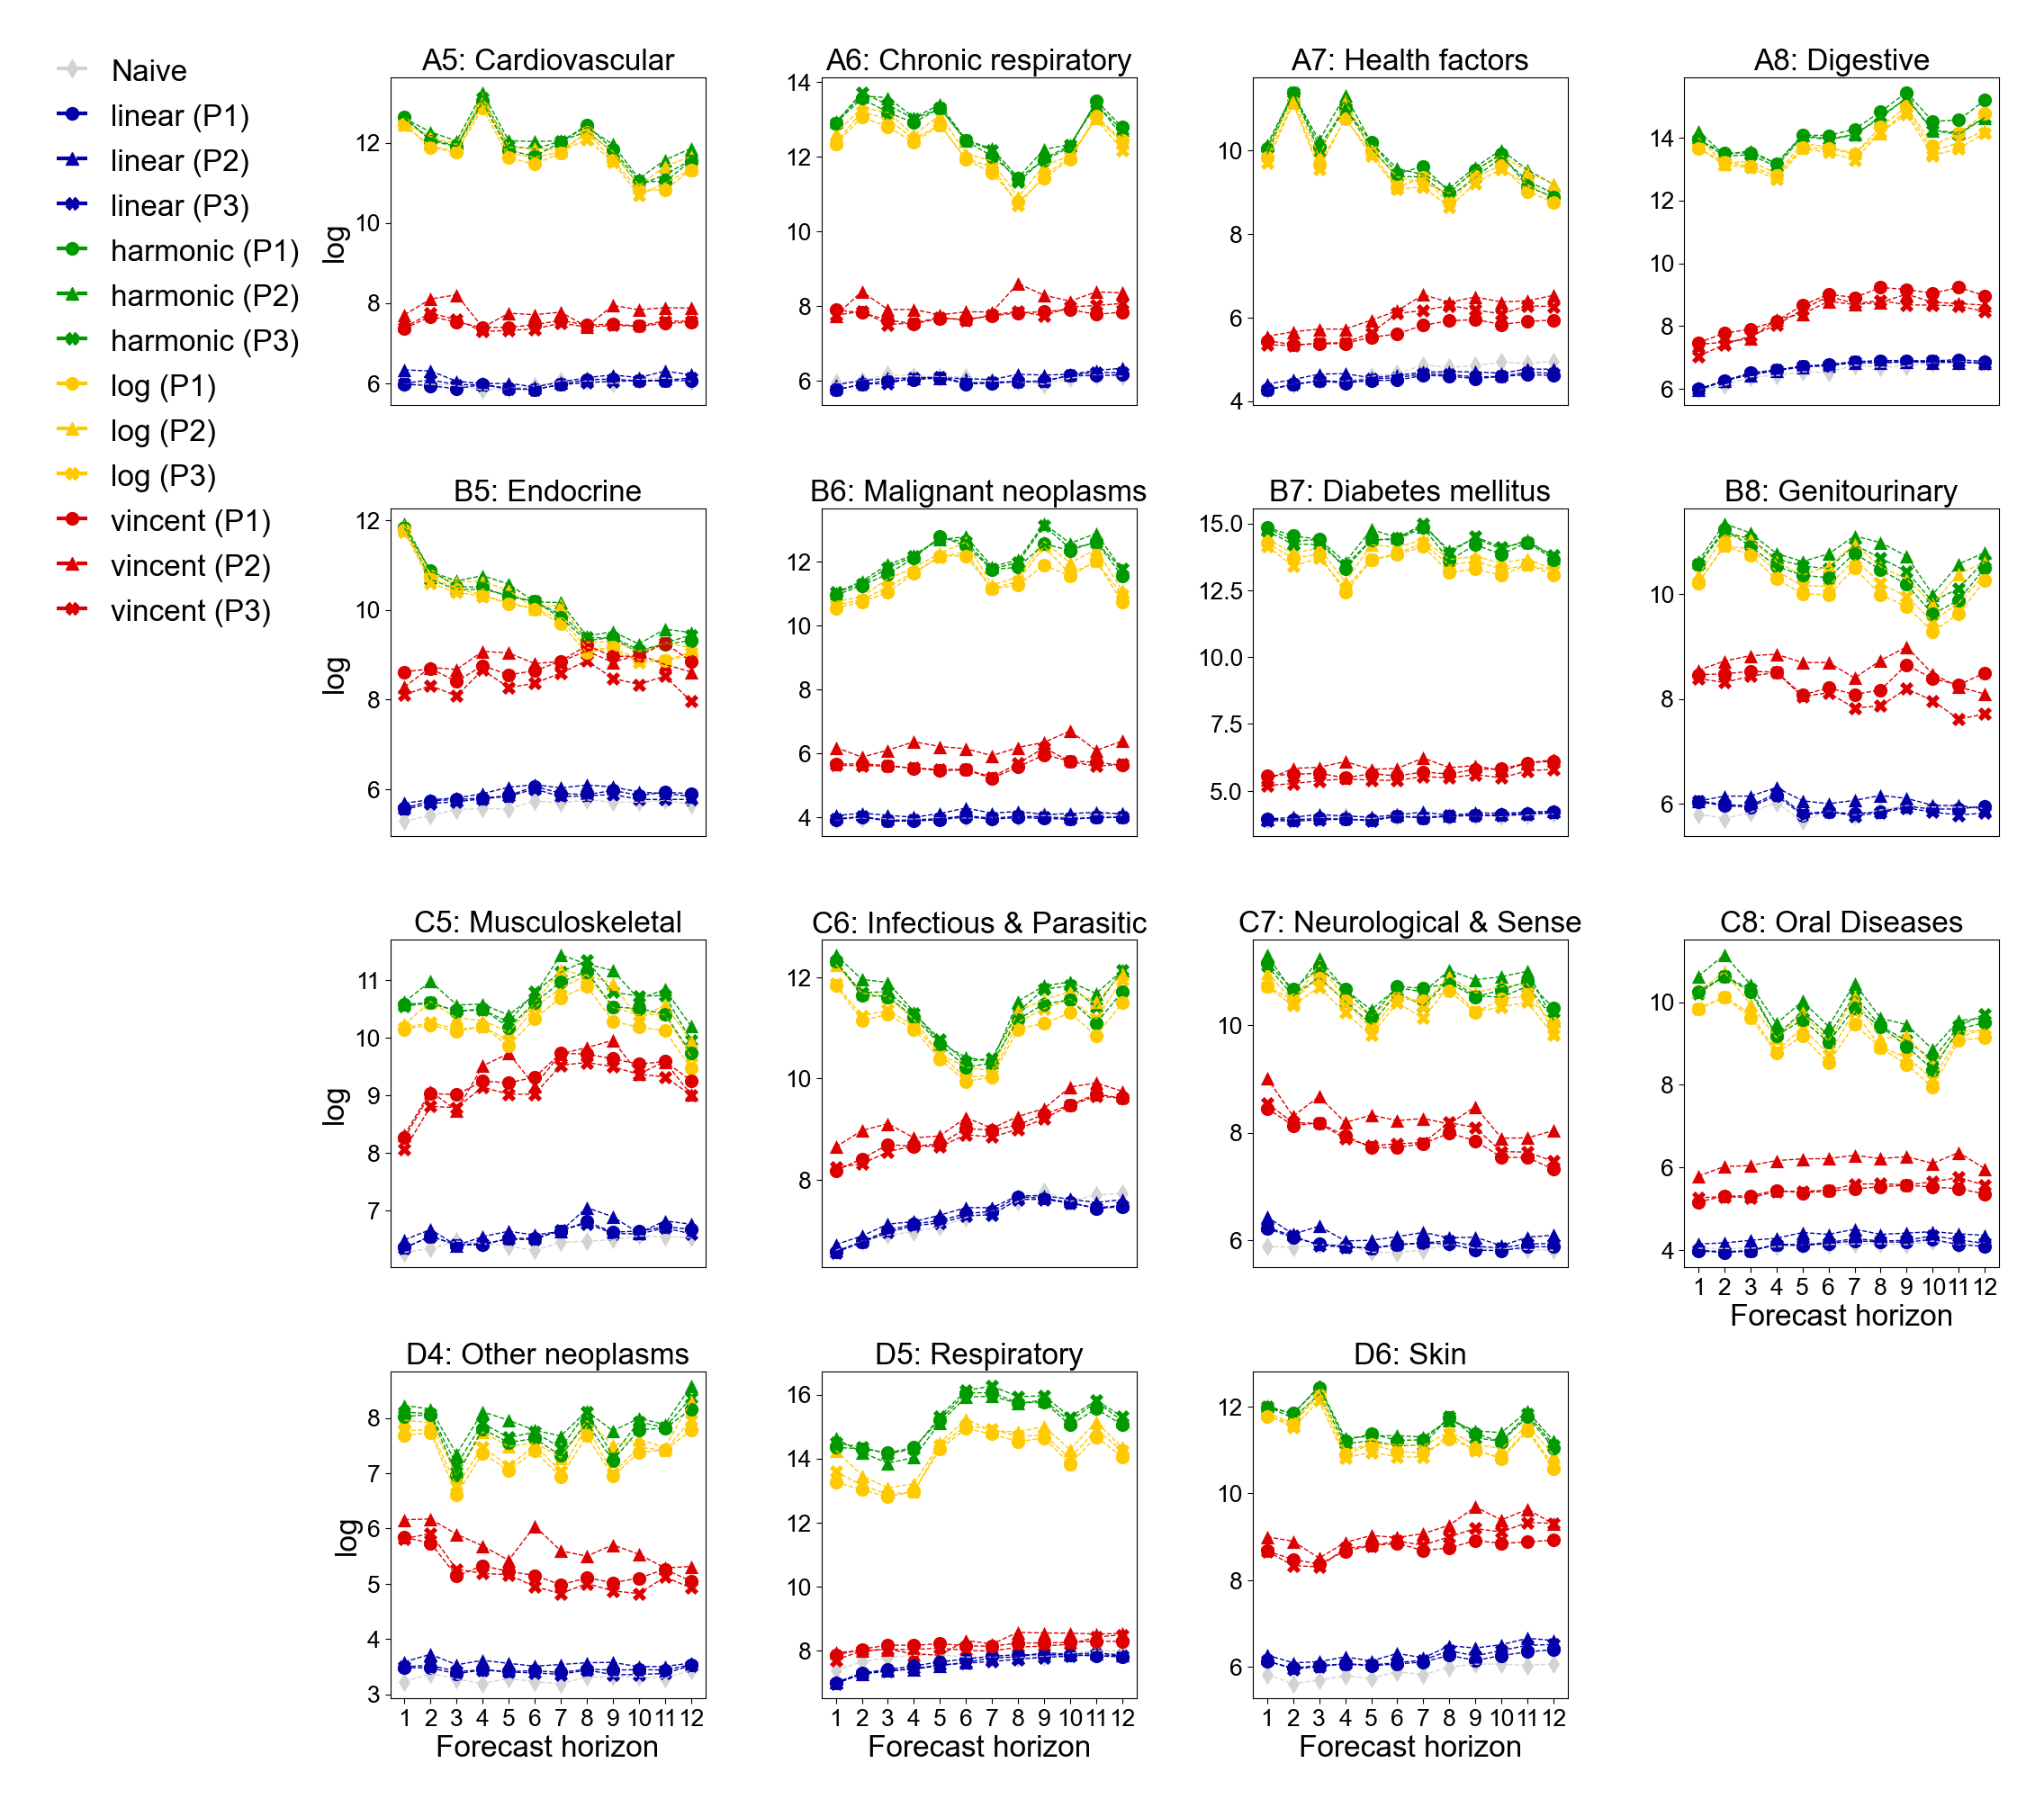

In [10]:
## Plot different combinatinons by disease
def plot_by_disease(target_variables_file, error_metric_directory, error_metric, output_directory_path, output_file):
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    if error_metric == 'crps_DENSITY_FORECAST':
        labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3']
    else:
        labs = ['A5', 'A6', 'A7', 'A8', 'B5', 'B6', 'B7', 'B8', 'C5', 'C6', 'C7', 'C8', 'D4', 'D5', 'D6']
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
            
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.tight_layout(pad=5.0)
    
    for i, disease in enumerate(disease_list): 
        row, col = divmod(i, 4)
        ax = axs[row, col]
        
        error_df = create_error_df(disease, error_metric_directory, error_metric)


        legend_handles = []
        # Can change depends on what models you want to visualize: all combi[0, 12:24]
        for model in error_df.columns.values[np.r_[0, 12:24]]:   
            color = color_picker(model)
            marker = marker_picker(model)
            if model == 'naive':
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=1, color='lightgrey')
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=120, color='lightgrey')
            else:
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=1, color=color)
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=120, color=color)
            # Create a legend handle combining line and scatter
            legend_handle = mpl.lines.Line2D([], [], color=line.get_color(), marker=marker, linestyle=line.get_linestyle(), markersize=10, linewidth=3)
            legend_handles.append((legend_handle, all_models.get(model, model)))
            
        ax.set_title(f'{labs[i]}: {rename_disease(disease)}', fontsize=24)
        if row == 3 or (row == 2 and col == 3):
            ax.set_xlabel('Forecast horizon', fontsize=24)
            x_ticks = np.arange(1, len(error_df.index.values)+1)  # Assuming error_df.index.values are numerical
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(error_df.index.values)
        else:
            ax.set_xticklabels([])
            ax.set_xticks([])
            
        if col == 0:
            if error_metric == 'crps_DENSITY_FORECAST':
                ax.set_ylabel(error_metric[:-17].upper(), fontsize=24)
            else:
                ax.set_ylabel(error_metric[:-17], fontsize=24)
            
        if row == 0 and col == 0:
            # Reorder the legend handles and labels
            custom_order = [0, 9, 5, 1, 10, 6, 2, 11, 7, 3, 12, 8, 4]
            reordered_handles = [legend_handles[i][0] for i in custom_order]
            reordered_labels = [legend_handles[i][1] for i in custom_order]
            
            ax.legend(reordered_handles, reordered_labels, bbox_to_anchor=(-0.25, 1.1), loc=0, borderaxespad=0, fontsize=24)
            
        ax.tick_params(axis='both', labelsize=19) 

    if len(disease_list) == 15:
        fig.delaxes(axs[3, 3])  # This removes the last (16th) subplot
        
    output_file = os.path.join(output_directory_path, output_file)
    plt.savefig(output_file)
        

# plot_by_disease('target_variables_new.txt', 'density_forecast_metrics', 'crps_DENSITY_FORECAST', 'for_plots', 'all_combi_CRPS.pdf')
plot_by_disease('target_variables_new.txt', 'density_forecast_metrics', 'log_DENSITY_FORECAST', 'for_plots', 'all_combi_log.pdf')

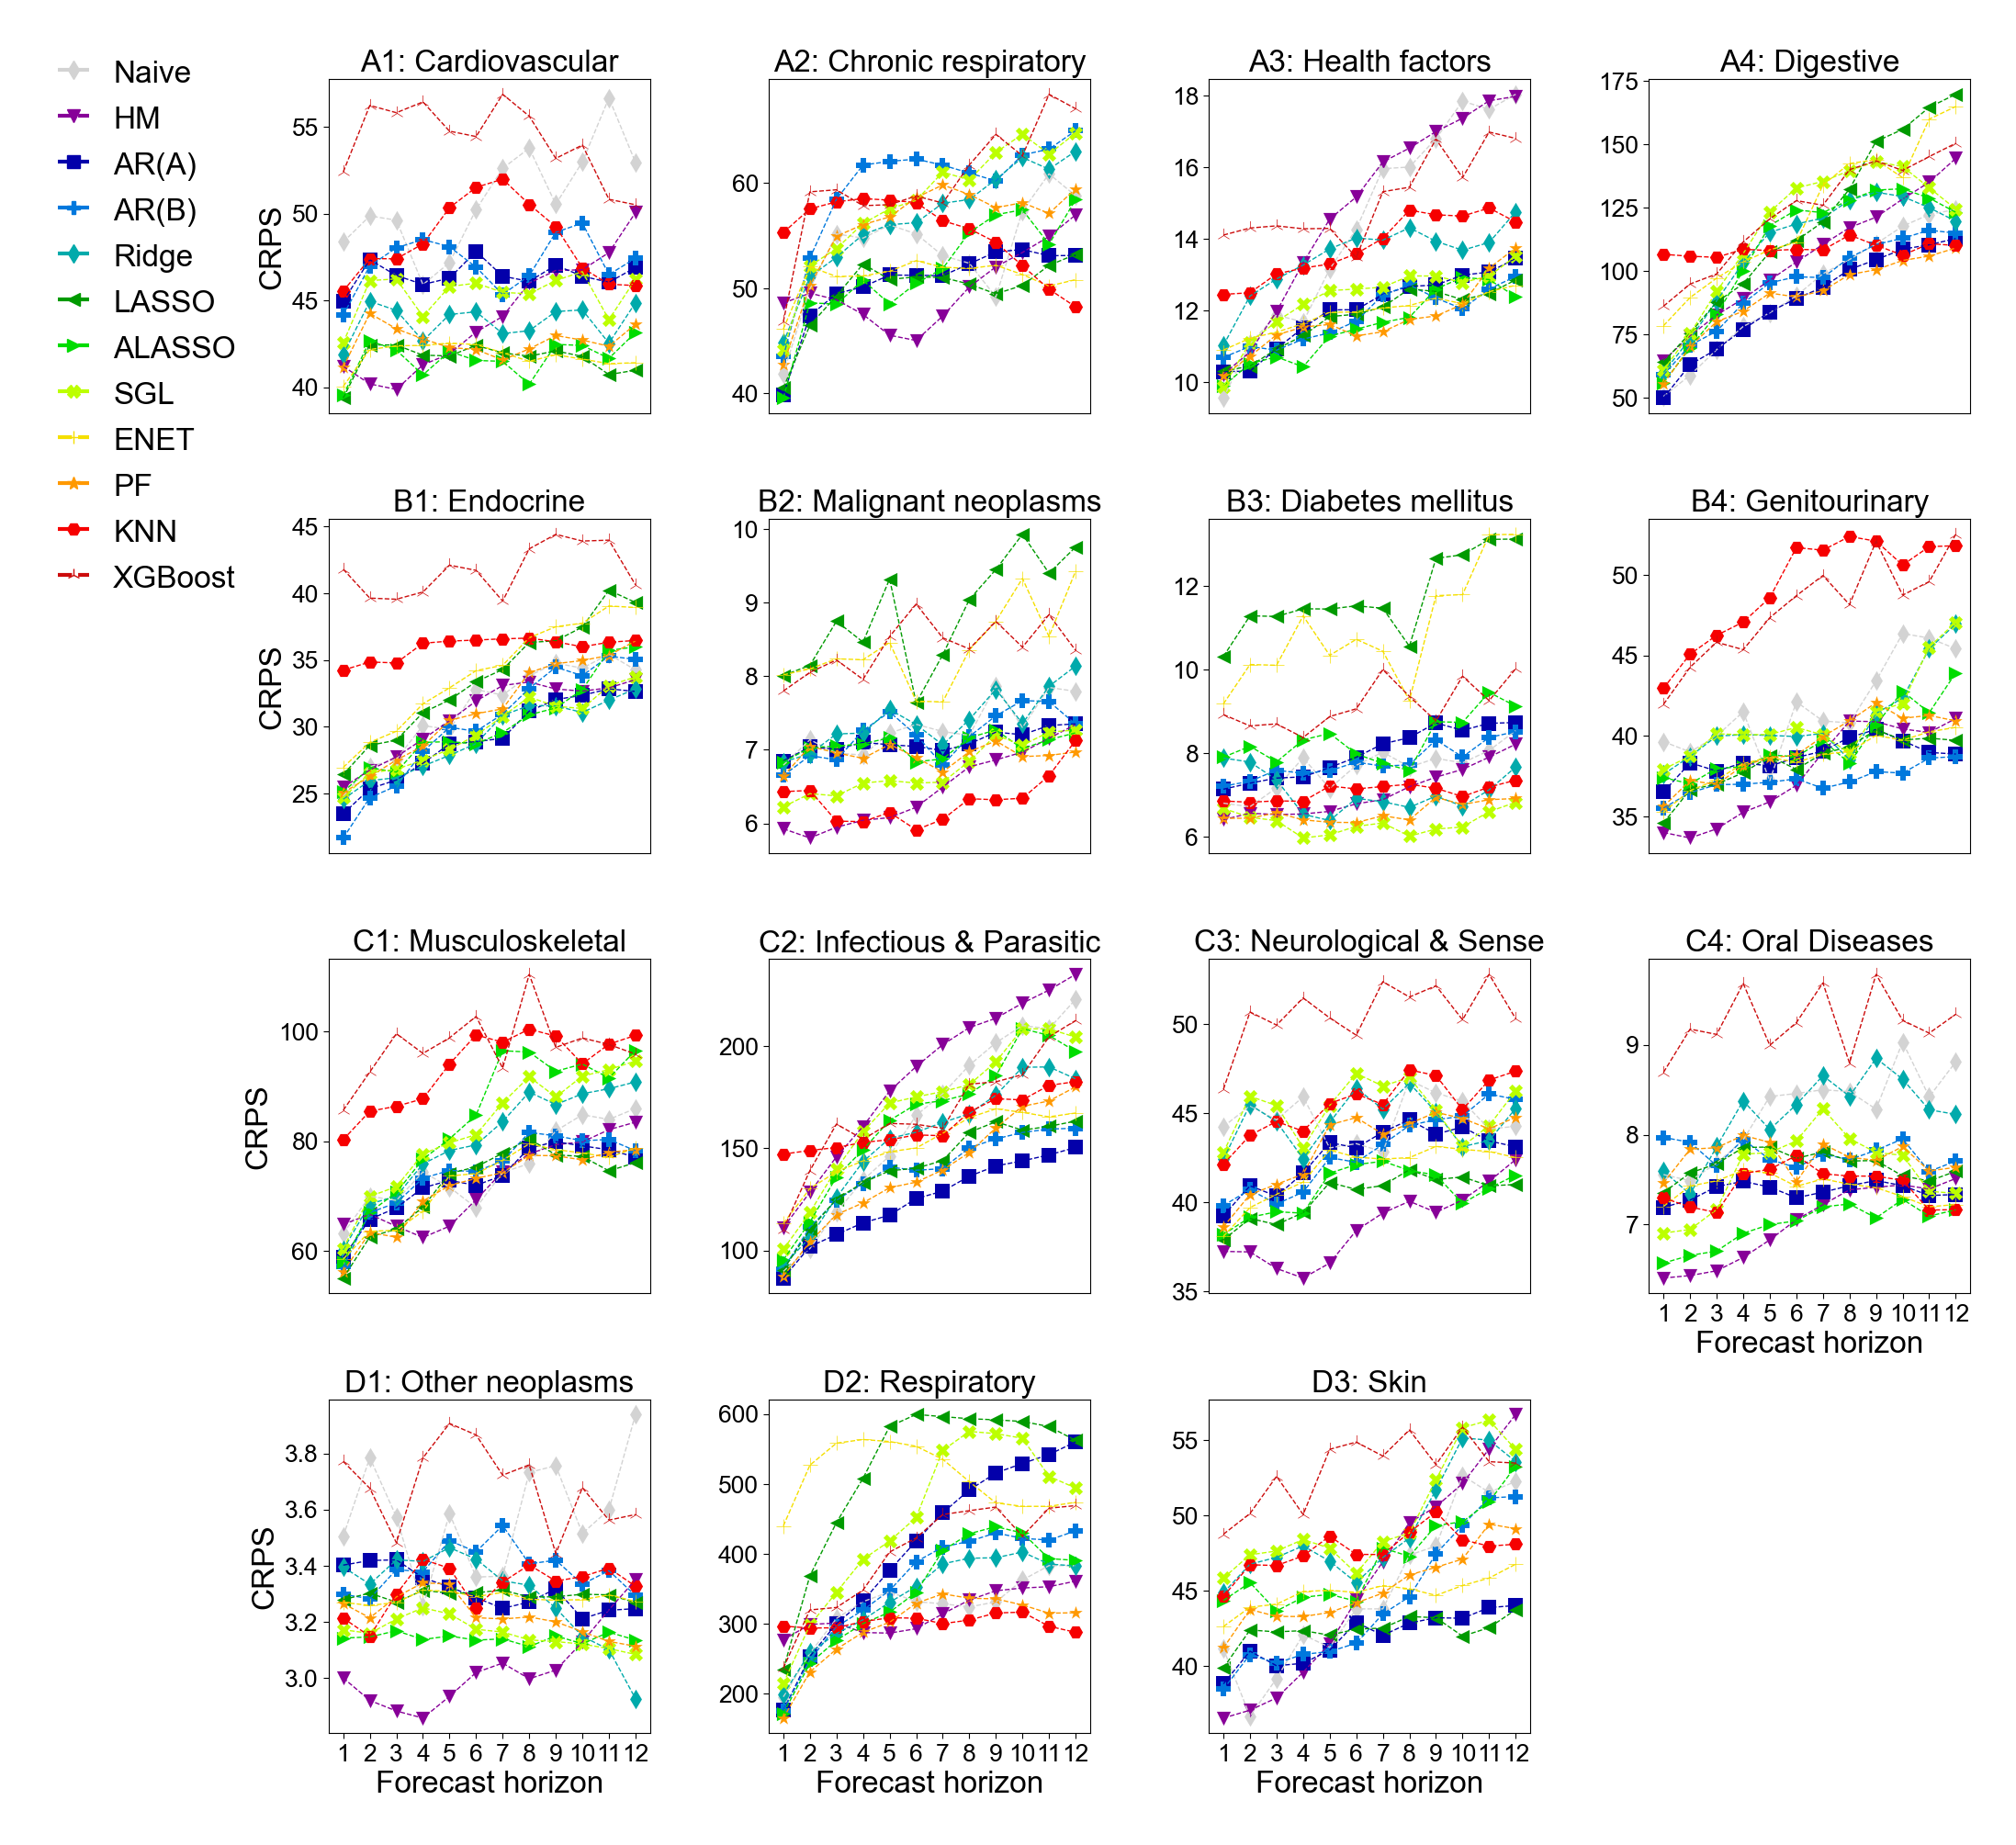

In [12]:
## Plot different individual models by disease
def plot_by_disease(target_variables_file, error_metric_directory, error_metric, output_directory_path, output_file):
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    if error_metric == 'crps_DENSITY_FORECAST':
        labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3']
    else:
        labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3']
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
            
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.tight_layout(pad=5.0)
    
    for i, disease in enumerate(disease_list): 
        row, col = divmod(i, 4)
        ax = axs[row, col]
        
        error_df = create_error_df(disease, error_metric_directory, error_metric)


        legend_handles = []
        
        for model in error_df.columns.values[np.r_[0:12]]:   
            color = color_picker(model)
            marker = marker_picker(model)
            if model == 'naive':
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=1, color='lightgrey')
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=120, color='lightgrey')
            else:
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=1, color=color)
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=120, color=color)
            # Create a legend handle combining line and scatter
            legend_handle = mpl.lines.Line2D([], [], color=line.get_color(), marker=marker, linestyle=line.get_linestyle(), markersize=10, linewidth=3)
            legend_handles.append((legend_handle, all_models.get(model, model)))
            
        ax.set_title(f'{labs[i]}: {rename_disease(disease)}', fontsize=24)
        if row == 3 or (row == 2 and col == 3):
            ax.set_xlabel('Forecast horizon', fontsize=24)
            x_ticks = np.arange(1, len(error_df.index.values)+1)  # Assuming error_df.index.values are numerical
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(error_df.index.values)
        else:
            ax.set_xticklabels([])
            ax.set_xticks([])
            
        if col == 0:
            if error_metric == 'crps_DENSITY_FORECAST':
                ax.set_ylabel(error_metric[:-17].upper(), fontsize=24)
            else:
                ax.set_ylabel(error_metric[:-17], fontsize=24)
            
        if row == 0 and col == 0:
            handles, labels = zip(*legend_handles)
            ax.legend(handles, labels, bbox_to_anchor=(-0.25, 1.1), loc=0, borderaxespad=0, fontsize=24)
            
        ax.tick_params(axis='both', labelsize=19) 

    if len(disease_list) == 15:
        fig.delaxes(axs[3, 3])  # This removes the last (16th) subplot
        
    output_file = os.path.join(output_directory_path, output_file)
    plt.savefig(output_file)
        

plot_by_disease('target_variables_new.txt', 'density_forecast_metrics', 'crps_DENSITY_FORECAST', 'for_plots', 'individual_CRPS.pdf')
# plot_by_disease('target_variables_new.txt', 'density_forecast_metrics', 'log_DENSITY_FORECAST', 'for_plots', 'individual_log.pdf')

In [22]:
def color_picker_for_ratio(min_model_name):
    Blues = cm.get_cmap('Blues')
    Greens = cm.get_cmap('Greens')
    Yellows = cm.get_cmap('YlOrBr')
    Reds = cm.get_cmap('Reds')
    color_dict = {
        'naive': 'lightgrey',
        'historymean': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.1)),
        'ar_pure': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        'ar_env': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.25)),
        'ridge': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.35)),
        'lasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        'alasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.55)),
        'sgl': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.65)),
        'elasticnet': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.72)),
        'purefactor': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.8)),
        'knn': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.86)),
        'xgboost': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.95)),
        
        'linearpool_P1': Blues(0.4),
        'linearpool_P2': Blues(0.7),
        'linearpool_P3': Blues(1.0),
        
        'harmonicpool_P1': Greens(0.4),
        'harmonicpool_P2': Greens(0.7),
        'harmonicpool_P3': Greens(1.0),
        
        'logpool_P1': Yellows(0.4),
        'logpool_P2': Yellows(0.7),
        'logpool_P3': Yellows(1.0),
        
        'vincentization_P1': Reds(0.4),
        'vincentization_P2': Reds(0.7),
        'vincentization_P3': Reds(1.0)
    }
    return color_dict[min_model_name] 

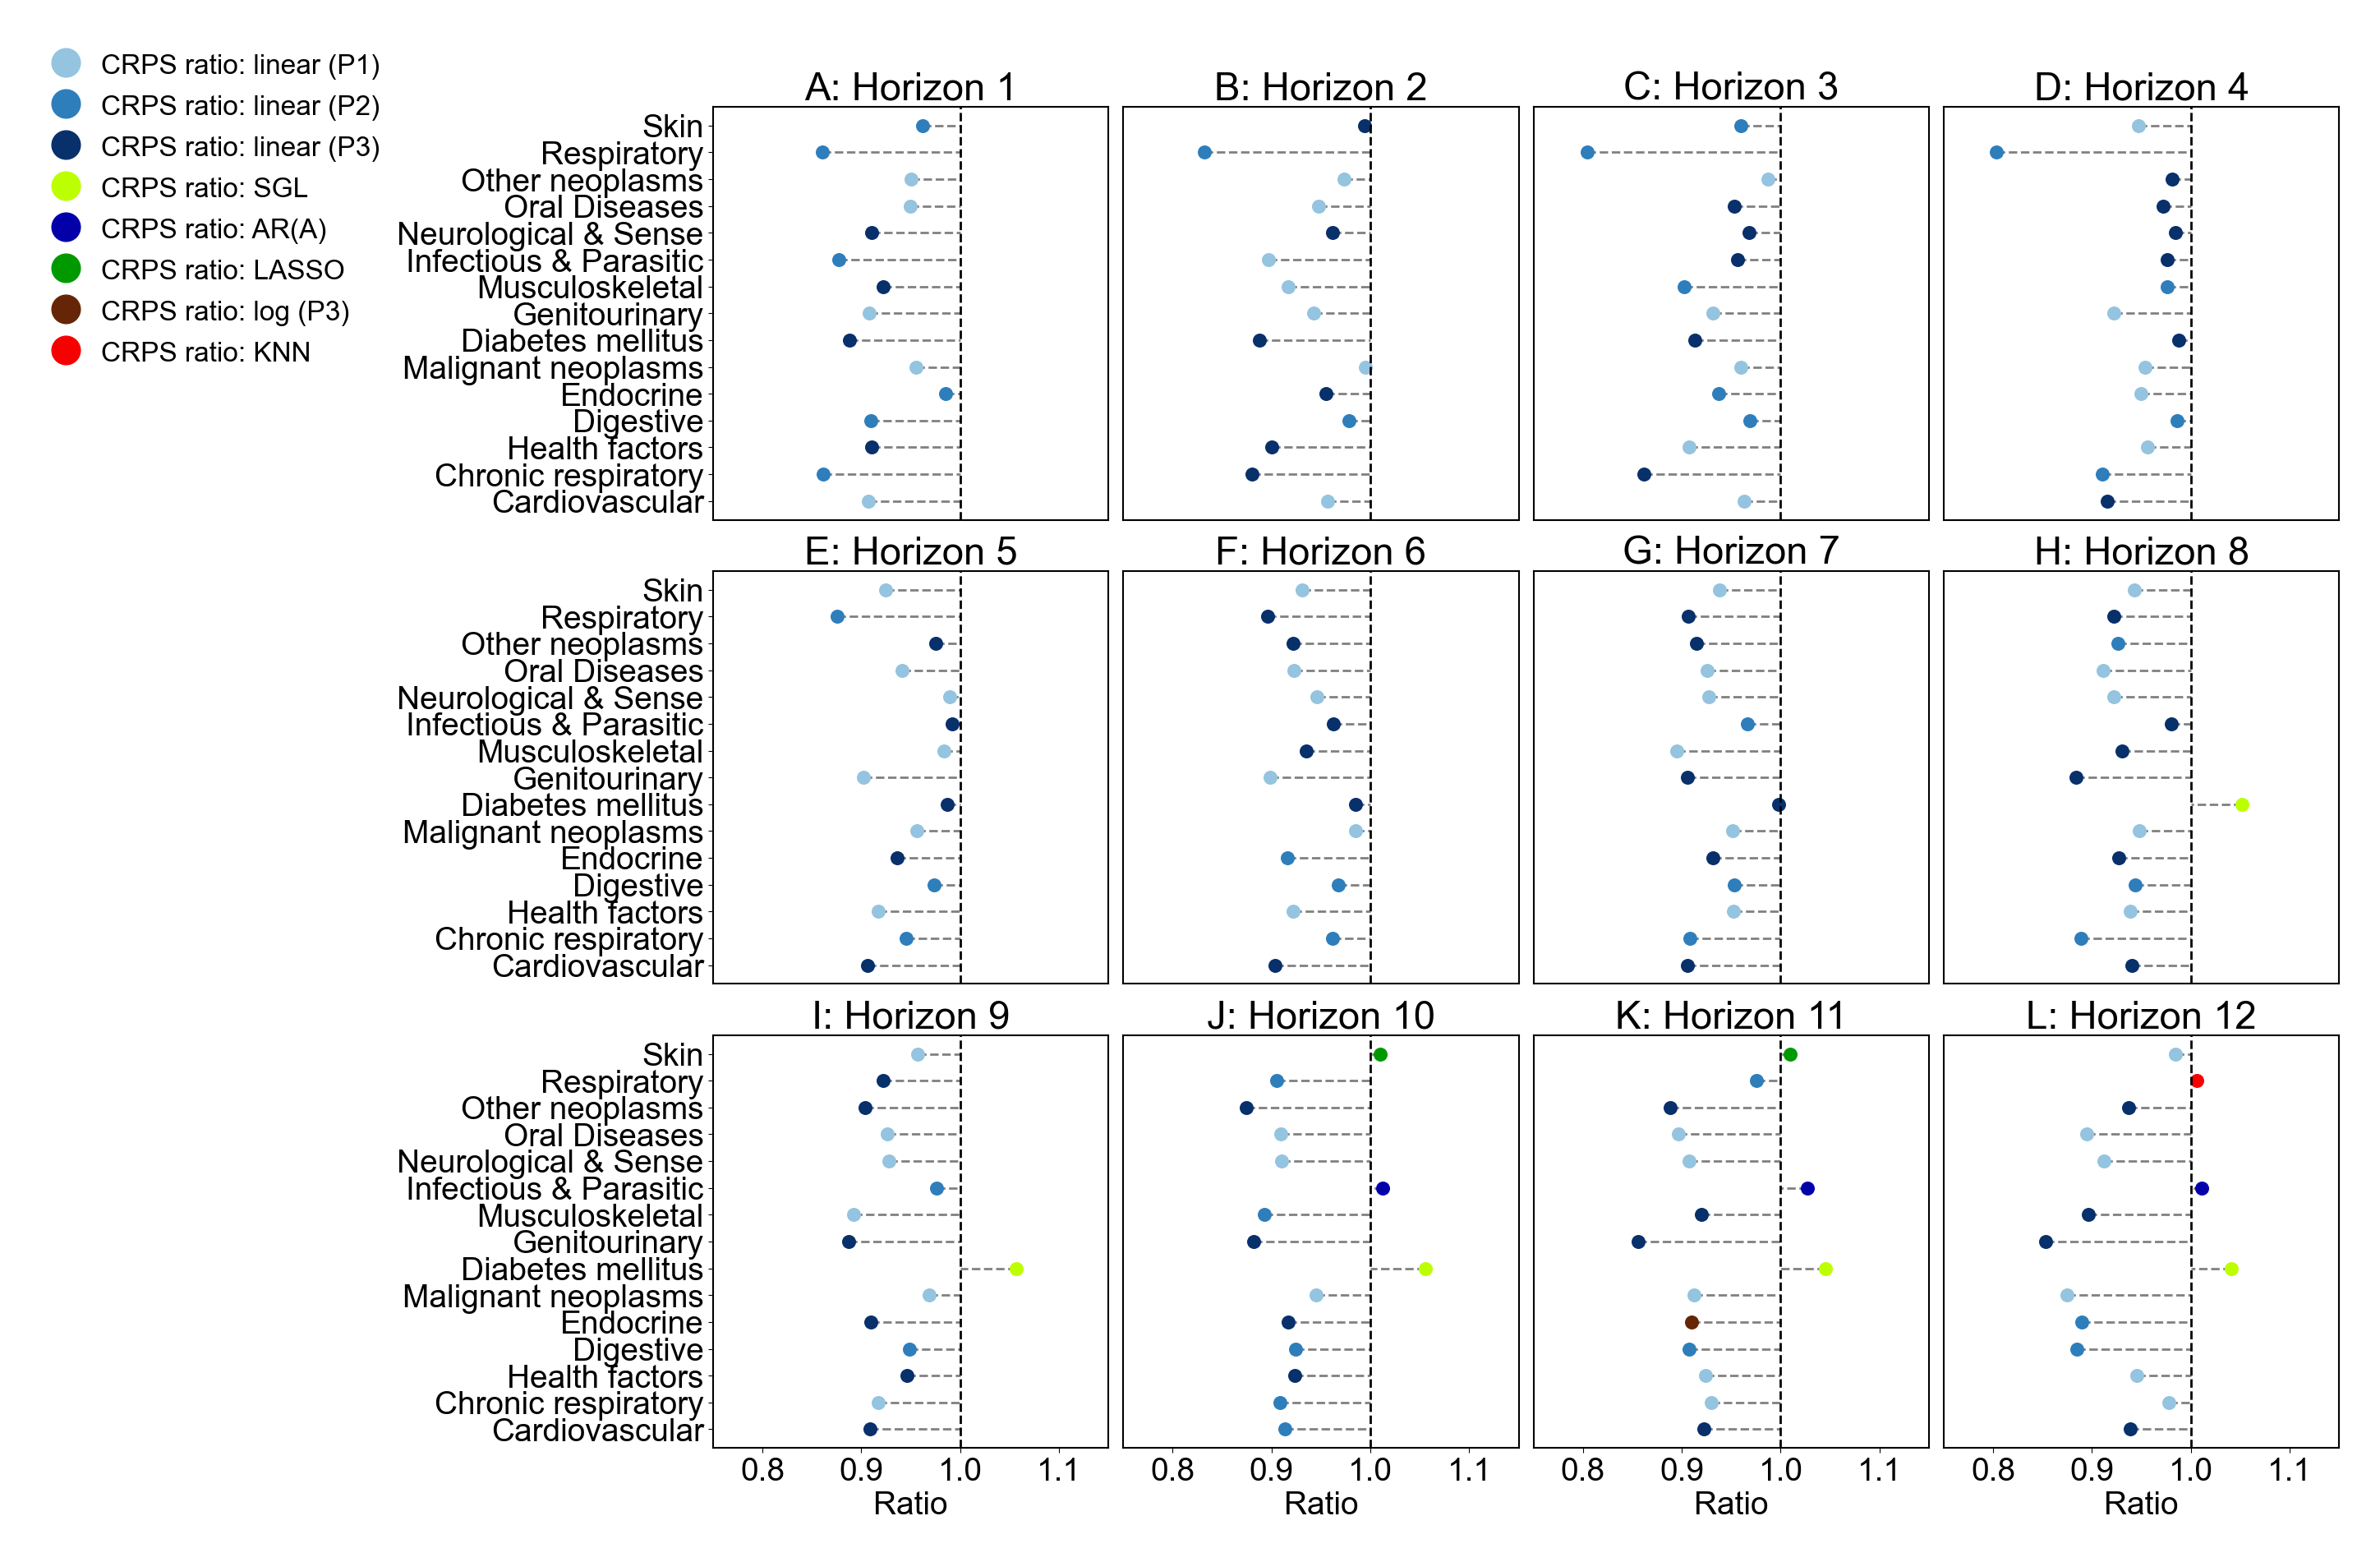

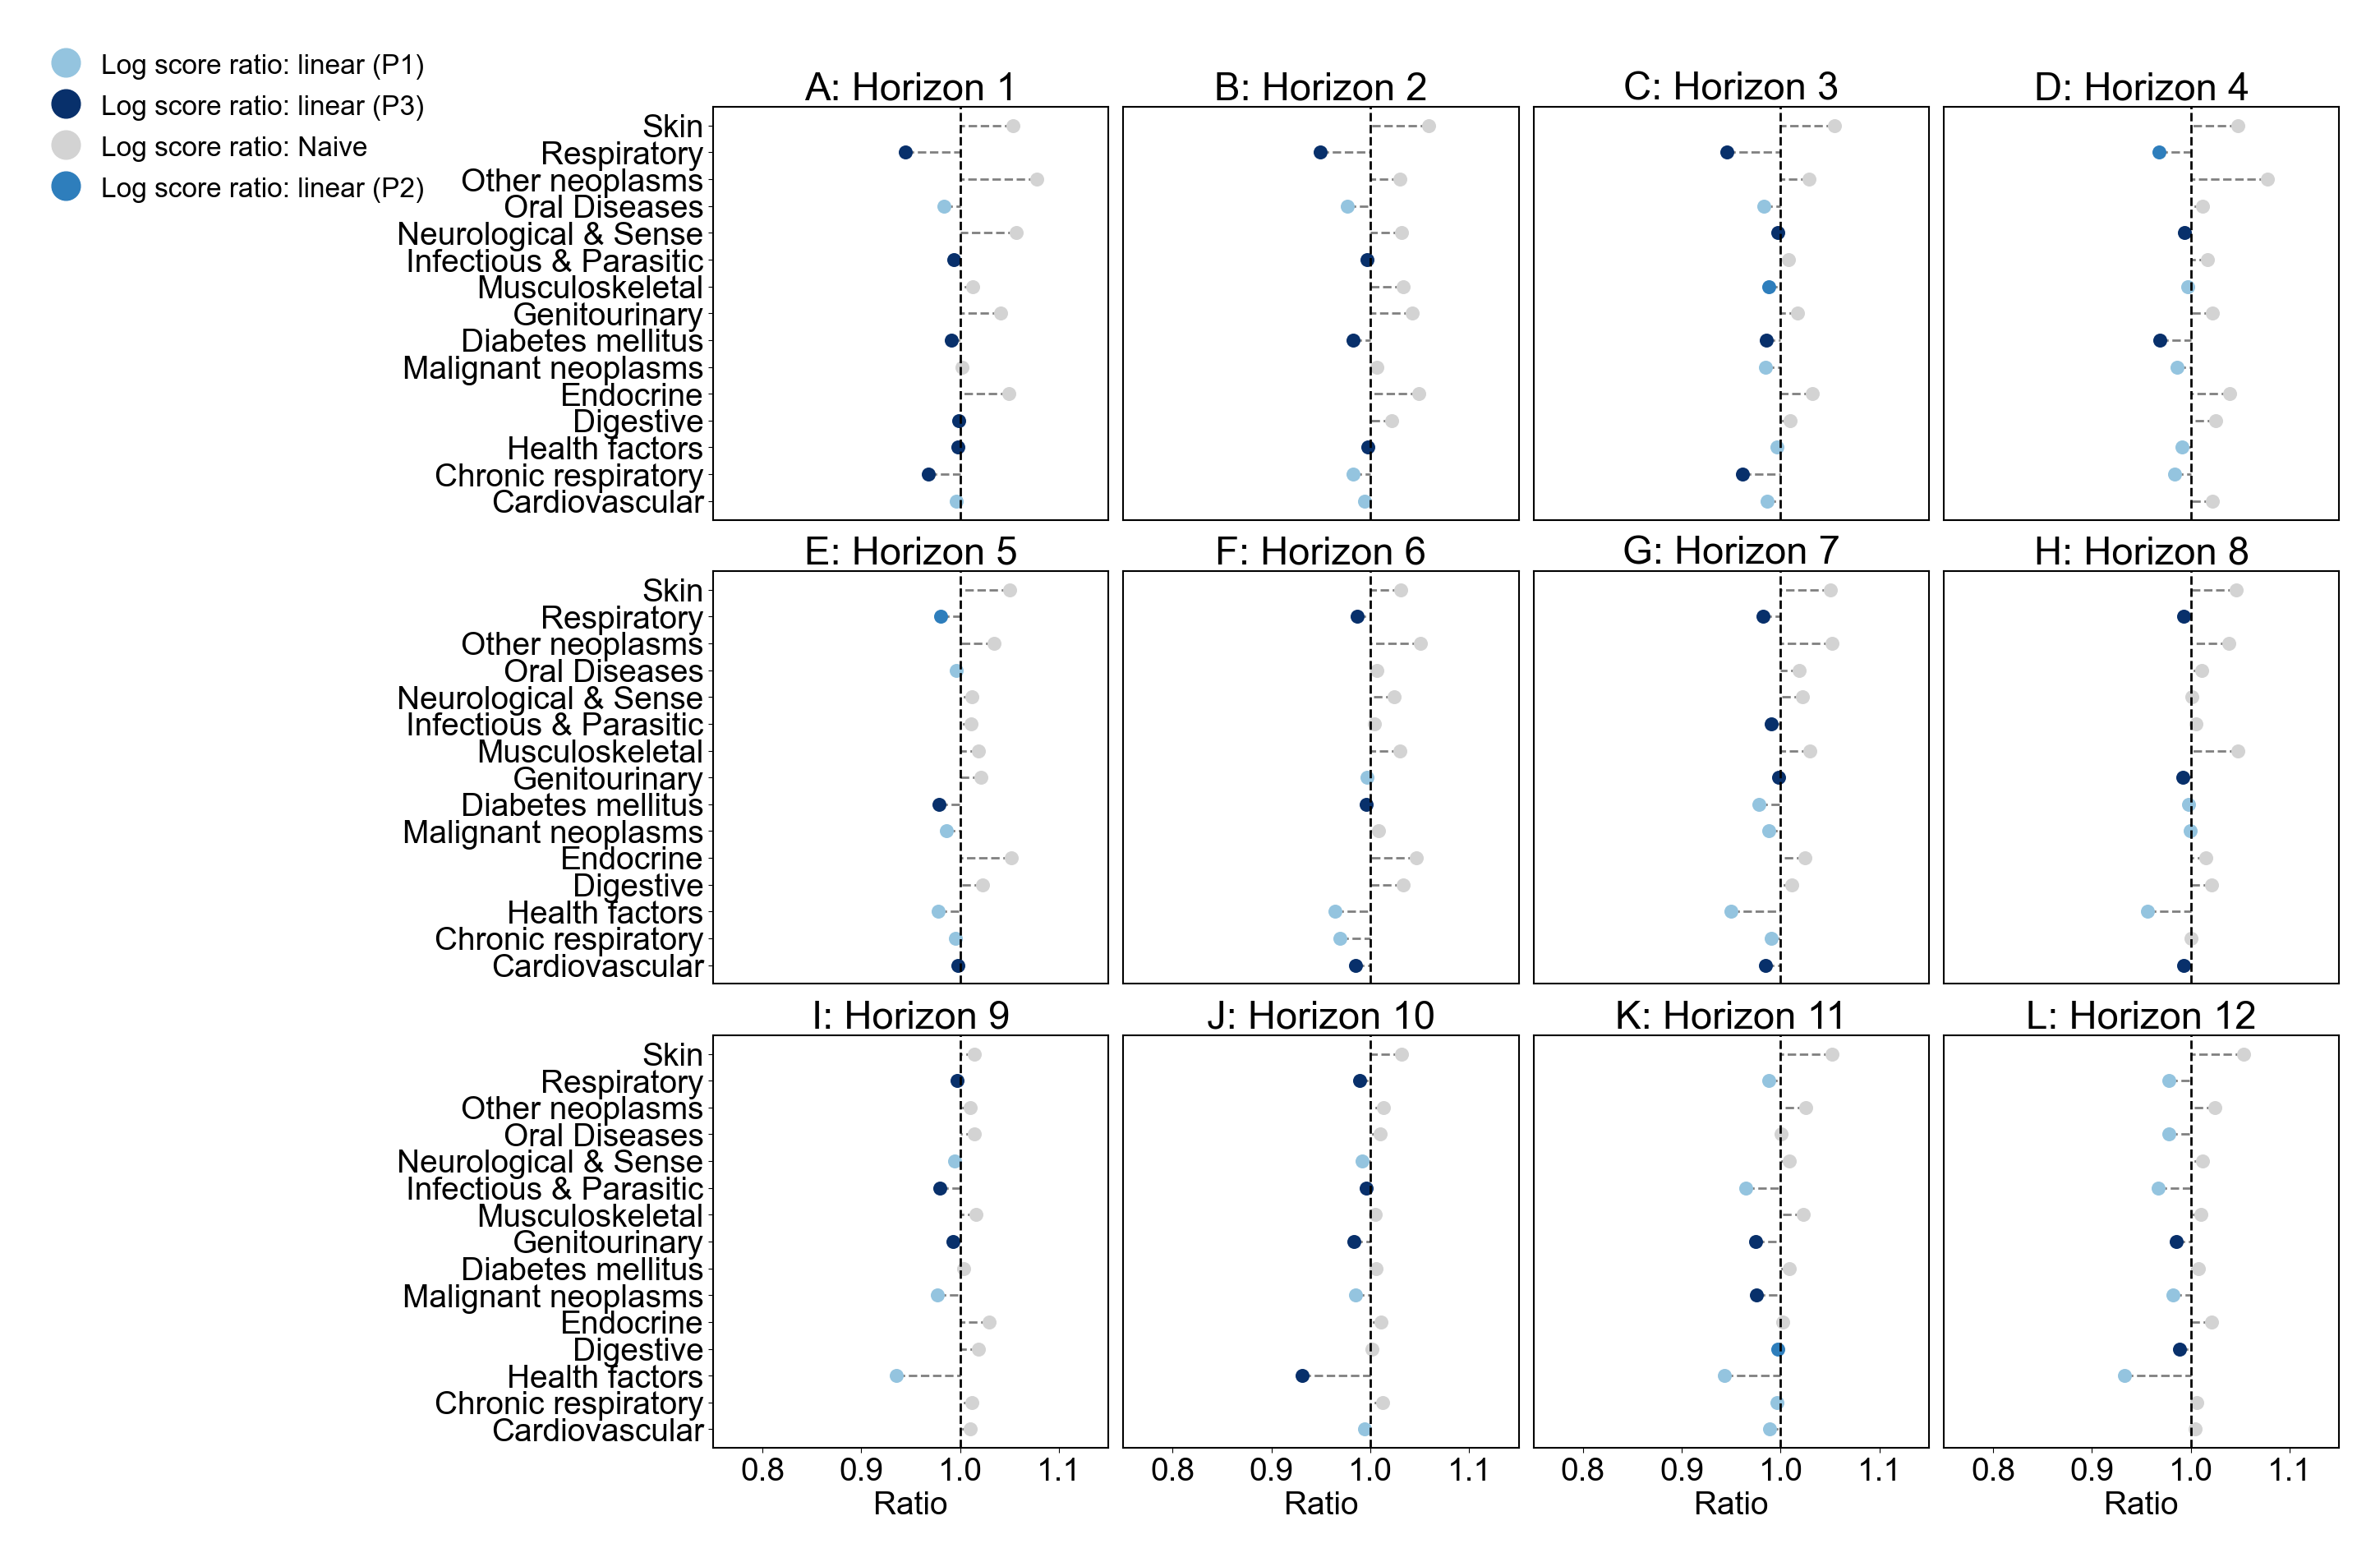

In [30]:
def plot_combined_plot(target_variables_file, error_metric_directory, crps_metric, log_metric, output_directory_path):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    
    labs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
    # Read diseases from file
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            disease = line.strip()
            disease_list.append(disease)
    # Rename diseases to D1 to D15
    disease_labels = [rename_disease(D) for D in disease_list]
    disease_mapping = dict(zip(disease_list, disease_labels))
    
    
    for error_metric, label_prefix in [(crps_metric, 'CRPS'), (log_metric, 'Log score')]:
        # Collect legend elements
        legend_elements = {}
        fig, axs = plt.subplots(3, 4, figsize=(24, 18))
        fig.tight_layout(pad=5.0)
        for h in range(1, 13):
            # Calculate subplot position
            row = ((h - 1) // 4)
            col = (h - 1) % 4
            ax = axs[row, col]

    #         ax.set_facecolor('#FBF4F3') # #FBF9F4

            for spine in ax.spines.values():
                spine.set_linewidth(1.5)


            ratios = []
            y_positions = []
            colors = []
            for d_idx, disease in enumerate(disease_list):
                # Read error data for the disease
                error_df = create_error_df(disease, error_metric_directory, error_metric)
                error_series = error_df.loc[h]

                # Get model names
                models = error_df.columns.values
                individual_models = models[0:12]  # Adjust indices if necessary
                combination_models = models[12:]  # Adjust indices if necessary

                # Get minimum error among individual models
                min_individual_error = error_series[individual_models].min()
                min_individual_model = error_series[individual_models].idxmin()

                # Get minimum error among combination models
                min_combination_error = error_series[combination_models].min()
                min_combination_model = error_series[combination_models].idxmin()

                # Compute ratio
                ratio = min_combination_error / min_individual_error
                ratios.append(ratio)
                y_positions.append(d_idx)

                # Determine color based on the model
                if ratio > 1:
                    color = color_picker_for_ratio(min_individual_model)
                    legend_key = f'{label_prefix} ratio: {all_models[min_individual_model]}'
                else:
                    color = color_picker_for_ratio(min_combination_model)
                    legend_key = f'{label_prefix} ratio: {all_models[min_combination_model]}'
                colors.append(color)

                if legend_key not in legend_elements:
                    legend_elements[legend_key] = color

                # Plot the point
                ax.scatter(ratio, d_idx, s=150, color=color, zorder=2)

                # Draw a vertical dashed line from the point to x=1                
                ax.plot([ratio, 1], [d_idx, d_idx], linestyle='--', linewidth=2, color='gray', zorder=1)

            # Set x-axis limits and draw vertical dashed line at x=1
            ax.set_xlim(0.75, 1.15)
            ax.axvline(x=1, linestyle='--', linewidth=2, color='black')

            # Set y-axis labels
            ax.set_yticks(range(len(disease_labels)))
            if col == 0:
                ax.set_yticklabels(disease_labels)
            else:
                ax.set_yticklabels([])
                ax.set_yticks([])

            # Set x-axis label
            if row == 2:
                ax.set_xlabel('Ratio', fontsize=28)
            else:
                ax.set_xticklabels([])
                ax.set_xticks([])

            ax.tick_params(axis='both', labelsize=28)

            # Set title as the horizon number
            ax.set_title(f'{labs[h-1]}: Horizon {h}', fontsize=34)

        # Create combined legend
        legend_handles = [
            Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=25, label=model)
            for model, color in legend_elements.items()
        ]
        fig.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(-0.18, 1.02), fontsize=24)

        # Adjust layout and save the figure
        output_file = f'{label_prefix}_ratios.pdf'
        plt.tight_layout()
        output_file = os.path.join(output_directory_path, output_file)
        plt.savefig(output_file)
    #     plt.close()


plot_combined_plot(
    'target_variables_new.txt',
    'density_forecast_metrics',
    'crps_DENSITY_FORECAST',
    'log_DENSITY_FORECAST',
    'for_plots'
)

### Plot forecast vs actual only in cardiovascular disease

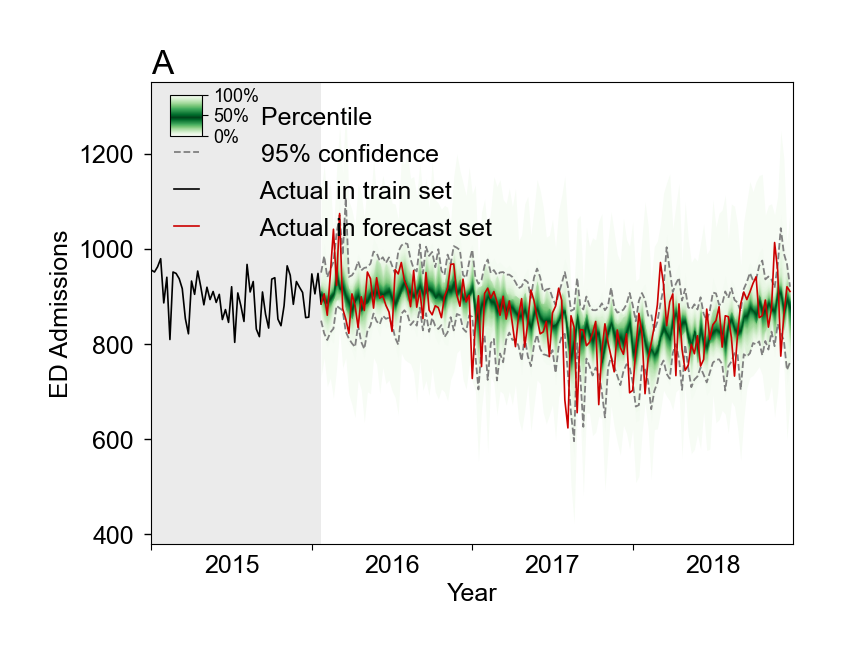

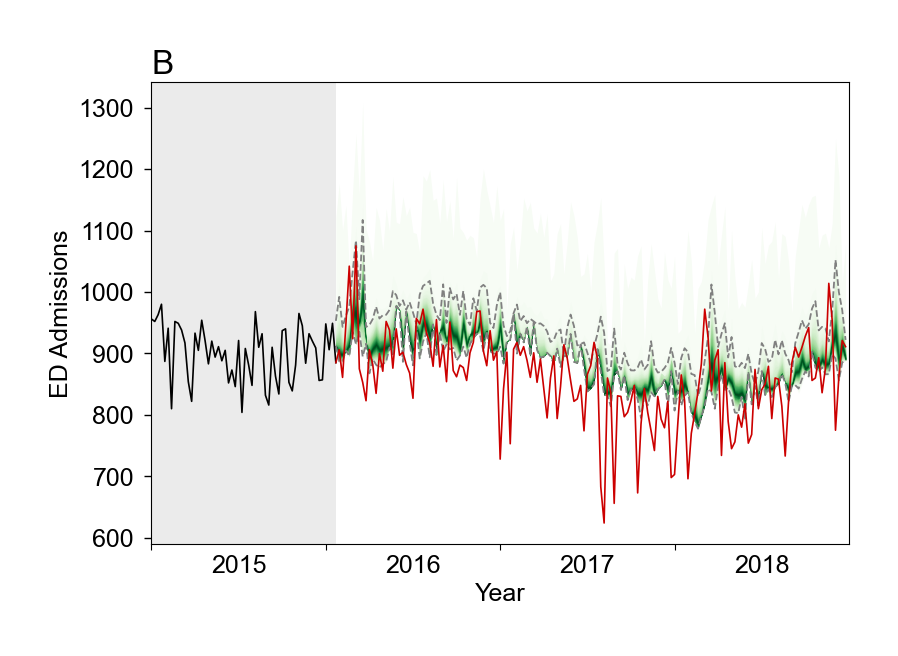

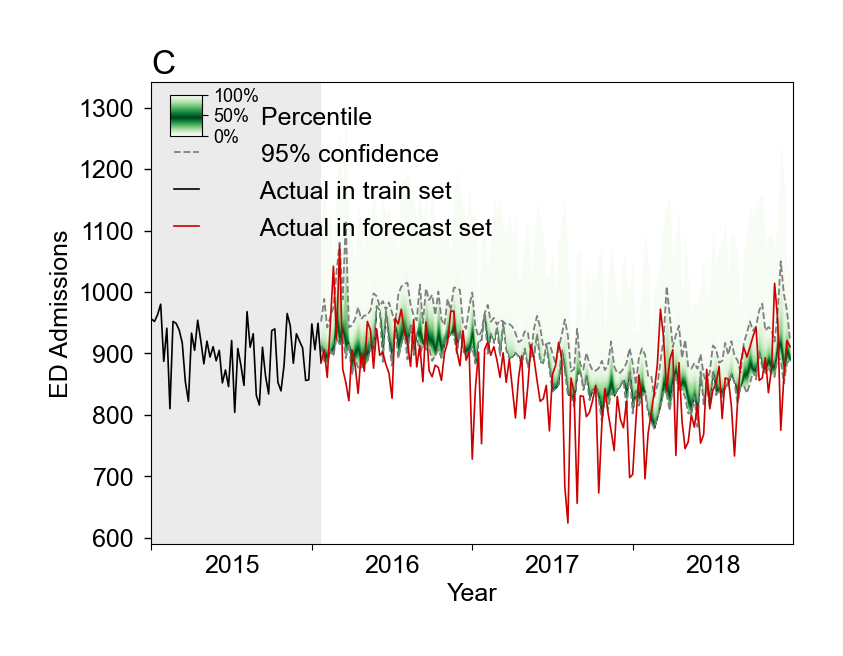

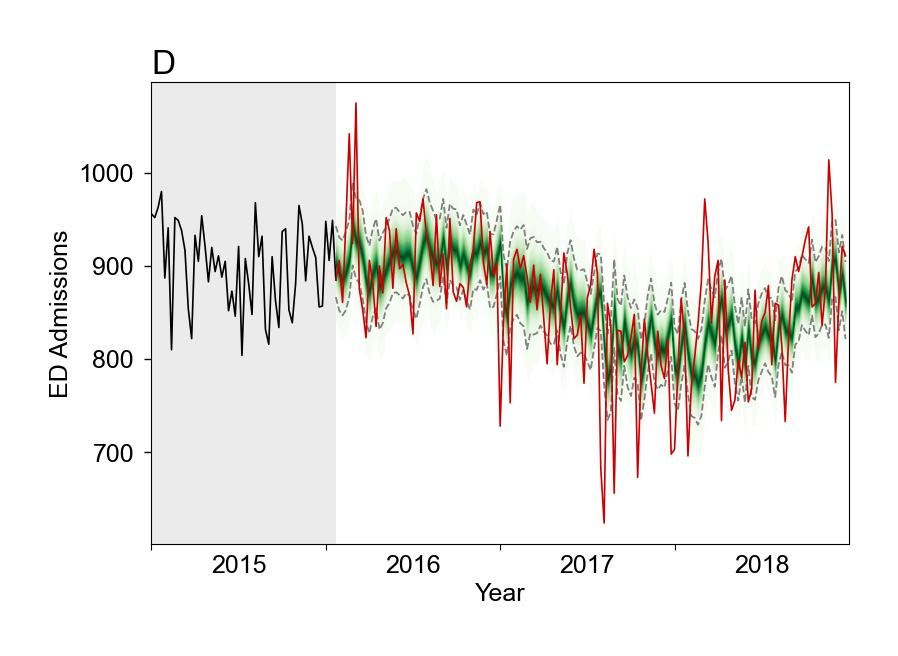

In [8]:
def single_plot(pred, lag, step, target_var, model, output_directory): # for density forecast submodels and combi density forecast
    labs = {'linearpool_P1': 'A', 'harmonicpool_P1': 'B', 'logpool_P1': 'C', 'vincentization_P1': 'D'}
    output_directory_path = os.path.join(output_directory, target_var)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    output_file = os.path.join(output_directory_path, F'{model} {step}-week.pdf')
    
    y_pred = pred.copy()
    fig, ax1 = plt.subplots(1,1, figsize=(9,6))
    # Set the x-axis limits
    plt.xlim([0,len(pred)])

    # Shade the training dataset
    epiweek_values = list(y_pred.index.values)
    first_valid_index = epiweek_values.index(y_pred['0'].first_valid_index()) # becasue the length of columns '0'-'999' is different from column target_var
    plt.axvspan(0, first_valid_index, facecolor='#d9d9d9', alpha=0.5)
    

    
    # Plot the polygon
    percentiles = np.linspace(0, 100, 101)
    cmap = cm.get_cmap('Greens')

    add_lable = True
    for p in reversed(percentiles):
        if p >= 100-p:
            upper_bound = []
            lower_bound = []
            for index, row in y_pred.iterrows():
                upper_bound.append(np.percentile(np.array(row[1:-1]), p))
                lower_bound.append(np.percentile(np.array(row[1:-1]), 100 - p))
            color_intensity = 1 - (p - 50) / 50  # Closer to 50% is darker
            color = cmap(color_intensity)
            ax1.fill_between(y_pred['epiweekplot'], lower_bound, upper_bound, color=color, alpha=1, label='      Percentile' if add_lable else None)
            add_lable = False
    
    # Plot the line
    # Calculate and plot the 2.5% and 97.5% lines
    upper_95 = [np.percentile(np.array(row[1:-1]), 97.5) for _, row in y_pred.iterrows()]
    lower_95 = [np.percentile(np.array(row[1:-1]), 2.5) for _, row in y_pred.iterrows()]
    ax1.plot(y_pred['epiweekplot'], upper_95, color='grey', linestyle='--', linewidth=1.3, label='      95% confidence')
    ax1.plot(y_pred['epiweekplot'], lower_95, color='grey', linestyle='--', linewidth=1.3)    
    
    ax1.plot(y_pred['epiweekplot'][:first_valid_index+1], y_pred[target_var][:first_valid_index+1], label='      Actual in train set', linestyle='-', linewidth=1.2, alpha=1, color='black')
    ax1.plot(y_pred['epiweekplot'][first_valid_index:], y_pred[target_var][first_valid_index:], label='      Actual in forecast set', linestyle='-', linewidth=1.2, alpha=1, color='#CC0000')
    
    
    # Plot settings
    ax1.set_xticks(y_pred['epiweekplot'][::52])
    ax1.set_xticklabels("")
    
    ax1.set_xticks(y_pred['epiweekplot'][26::52], minor=True)
    start_range = int(y_pred['epiweekplot'][0][1:5])
    end_range = int(y_pred['epiweekplot'][-1][1:5])+1
    ax1.set_xticklabels(range(start_range,end_range), minor=True)

    ax1.tick_params(axis='x', which='minor', length=0, width=0, pad=7.5, labelsize=18)
    ax1.tick_params(axis='y', which='major', length=5, width=1, pad=7.5, labelsize=18)

    plt.title(F'{labs[model]}', fontsize=24, loc='left')
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('ED Admissions', fontsize=18)




    # Add color bars
    if model == 'linearpool_P1' or model == 'logpool_P1':
        reversed_cmap = cmap.reversed()
        colors = cmap(np.linspace(0, 1, 100))  # First half (0-50)
        colors_reversed = reversed_cmap(np.linspace(0, 1, 128))  # Second half (50-100)
        symmetric_colors = np.vstack((colors, colors_reversed))  # Stack them vertically
        symmetric_cmap = LinearSegmentedColormap.from_list("symmetric_Greens", symmetric_colors)

        norm = Normalize(vmin=0, vmax=100)
        sm = ScalarMappable(cmap=symmetric_cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, shrink=0.08, aspect=1.3)
        cbar.ax.tick_params(labelsize=13)
        cbar.ax.set_position([0.146, 0.78, 0.035, 0.09])
        cbar.set_ticks([0, 50, 100])
        cbar.set_ticklabels(['0%', '50%', '100%'])


        plt.legend(loc='upper left', fontsize=18)
    plt.savefig(output_file)


def data_setup(lag, step, target_var, model):
    y_pred = pd.read_csv(F'{target_var}/combi_samples/L{lag}_S{step}/{model}.csv', parse_dates = [0], dayfirst = True)

    y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
    y_pred = y_pred.set_index('epiweek')
    y_pred = y_pred.drop(target_var, axis=1)


    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_pred_full = pd.concat([y_full.iloc[313:], y_pred], axis=1) # start from 201501
    y_pred_full['epiweekplot'] = y_pred_full.index
    y_pred_full['epiweekplot'] = y_pred_full['epiweekplot'].apply(create_epiweekplot)

    return y_pred_full

def plot_individual(lag, step, target_var, model, output_directory):
    y_pred = data_setup(lag, step, target_var, model)
    single_plot(y_pred, lag, step, target_var, model, output_directory)




def plot_disease(lag, step, target_var, model, output_directory):
    plot_individual(lag, step, target_var, model, output_directory)



for model in ['linearpool_P1', 'harmonicpool_P1', 'logpool_P1', 'vincentization_P1']:
    plot_disease(8, 1, 'Cardiovascular disease', model, 'distribution')

### plot PDF of 4 combinations

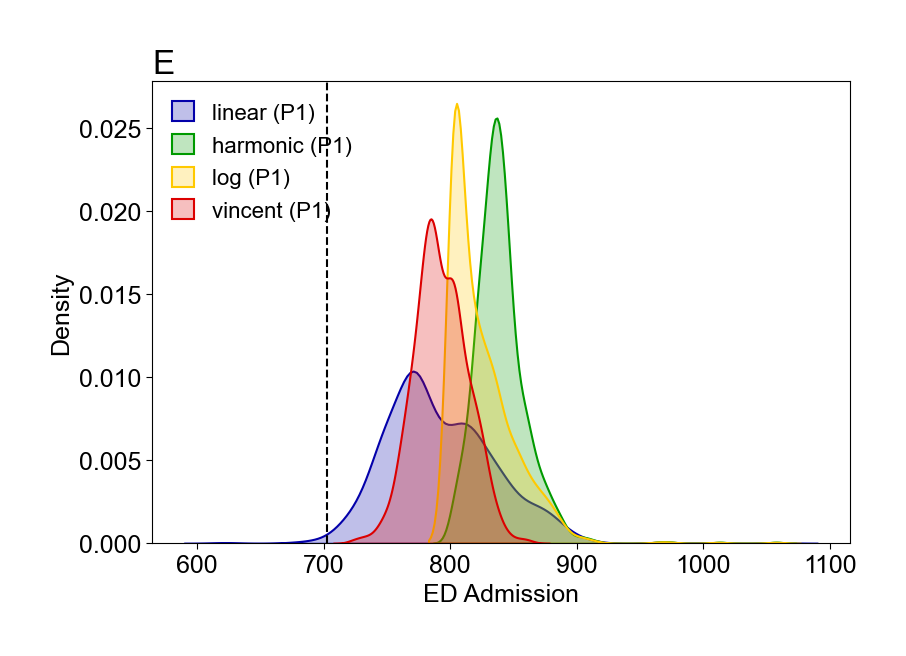

In [12]:
P1_combinaitons = ['linearpool_P1', 'harmonicpool_P1', 'logpool_P1', 'vincentization_P1']
plt.figure(figsize=(9, 6))
for model in P1_combinaitons:
    first_week_pred = pd.read_csv(F'Cardiovascular disease/combi_samples/L8_S1/{model}.csv', parse_dates = [0], dayfirst = True)
    first_week_pred['epiweek'] = first_week_pred['epiweek'].apply(create_epiweek_fromstr)
    first_week_pred = first_week_pred.set_index('epiweek') 

    data = first_week_pred.iloc[101, 1:].values  # Epiweek: 201801 


    sns.kdeplot(data, label=all_models[model], color = color_picker(model), linewidth=1.5, fill=True) # all_models is dictionary here
plt.axvline(x=first_week_pred.iloc[101, 0], linestyle='--', linewidth=1.5, color='black')
plt.title('E', fontsize=24, loc='left')
plt.xlabel('ED Admission', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=16)
plt.savefig('distribution/Cardiovascular disease/201801_P1_combis.pdf')

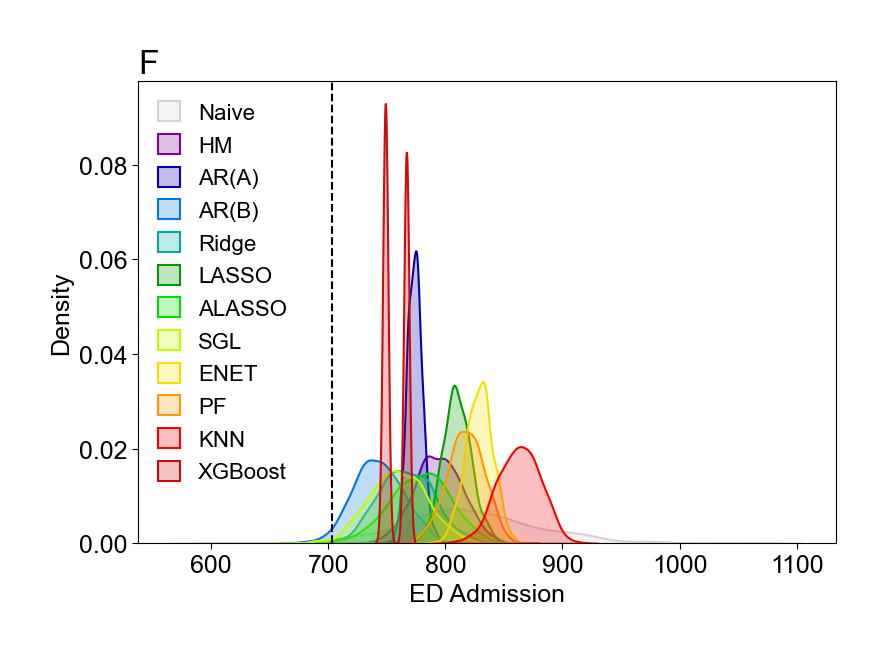

In [13]:
all_models_list = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ridge', 'lasso', 'alasso', 'sgl',
                 'elasticnet', 'purefactor', 'knn', 'xgboost']
plt.figure(figsize=(9, 6))
for model in all_models_list:
    first_week_pred = pd.read_csv(F'Cardiovascular disease/pred/L8_S1/{model}.csv', parse_dates = [0], dayfirst = True)
    first_week_pred['epiweek'] = first_week_pred['epiweek'].apply(create_epiweek_fromstr)
    first_week_pred = first_week_pred.set_index('epiweek') 

    data = first_week_pred.iloc[101, 1:].values   

    if model == 'naive':
        sns.kdeplot(data, label=all_models[model], linewidth=1.5, color='lightgrey', fill=True)
    else:
        sns.kdeplot(data, label=all_models[model], linewidth=1.5, color=color_picker(model), fill=True) # all_models is dictionary here
plt.axvline(x=first_week_pred.iloc[101, 0], linestyle='--', linewidth=1.5, color='black')
plt.title('F', fontsize=24, loc='left')
plt.xlabel('ED Admission', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=16)
plt.savefig('distribution/Cardiovascular disease/201801_individual.pdf')

## create the table for numbers of non-equivalence between simple models and combinations

In [7]:
all_combinations_P1 = ['linearpool_P1', 'harmonicpool_P1', 'logpool_P1', 'vincentization_P1']
all_combinations_P2 = ['linearpool_P2', 'harmonicpool_P2', 'logpool_P2', 'vincentization_P2']
all_combinations_P3 = ['linearpool_P3', 'harmonicpool_P3', 'logpool_P3', 'vincentization_P3']

def number_NE(target_variables_file, pvalue_directory, output_directory_path):
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    num_df = pd.DataFrame(index=disease_list, columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    for disease in disease_list:
        pvalue_dir = os.path.join(disease, pvalue_directory)
        for filename in os.listdir(pvalue_dir):
            pvalue_file = os.path.join(pvalue_dir, filename)
            if os.path.isfile(pvalue_file):
                pvalue = pd.read_csv(pvalue_file, parse_dates = [0], index_col = 0)
                MvsC = pvalue.loc[all_models, all_combinations]   # all_models vs all_combinations, P1, P2, P3
                num = (MvsC == -1).sum().sum()
                
                pos_S = filename.find('S') + 1  # +1 to start after 'S'
                pos_c = filename.find('.')
                # Extract the substring
                num_df.loc[disease, int(filename[pos_S:pos_c])] = num
    output_file = os.path.join(output_directory_path, 'num_of_NE_all.csv') # remember to change the name here for all the cases
    num_df.to_csv(output_file)

number_NE('target_variables_new.txt', 'pvalue', 'for_table')

### 测试

In [68]:
sb = create_error_df('Cardiovascular disease', 'density_forecast_metrics', 'crps_DENSITY_FORECAST')
sb

naive  historymean    ar_pure     ar_env      ridge      lasso  \
1   48.366682    41.203110  44.961337  44.156662  41.889587  39.385381   
2   49.866785    40.191155  47.343395  46.988764  44.951388  42.438397   
3   49.623464    39.875167  46.435653  48.031673  44.424718  42.432876   
4   45.911044    41.296781  45.922696  48.506930  42.674877  41.846804   
5   47.176452    41.921349  46.282183  48.097245  44.191588  41.805295   
6   50.233158    43.180913  47.827497  46.912866  44.346598  42.410880   
7   52.604681    44.076557  46.395327  45.347912  43.091568  41.978660   
8   53.768783    46.001510  46.099265  46.424533  43.257699  41.791760   
9   50.539227    46.724647  47.029673  48.925638  44.360044  42.094060   
10  52.977066    46.765717  46.395722  49.454696  44.454760  41.777766   
11  56.664111    47.756328  46.048104  46.489929  42.539086  40.730570   
12  52.947601    50.064087  46.900382  47.432637  44.872074  40.981511   

       alasso        sgl  elasticnet  purefactor  ...  logpool_P3  \
1   39.533533  42.561471   40.052082   41.163881  ...   46.909508   
2   42.673826  46.143732   42.174061   44.253992  ...   48.365534   
3   42.138813  46.238642   42.388343   43.365737  ...   48.257988   
4   40.713273  44.080679   42.409449   42.787100  ...   51.406617   
5   42.066149  45.803073   42.546292   42.288400  ...   48.501988   
6   41.543362  45.995265   42.459870   42.174699  ...   48.811235   
7   41.492970  45.465445   41.989480   41.573403  ...   48.171291   
8   40.172128  45.380684   41.495526   42.210184  ...   49.158397   
9   42.468252  46.149403   41.868961   42.980899  ...   47.214948   
10  42.407468  46.657510   41.624129   42.715959  ...   46.042059   
11  41.666556  43.890280   41.358972   42.364842  ...   45.881444   
12  43.151763  46.227969   41.412174   43.622586  ...   46.758722   

    vincentization_P3  linearpool_P2  harmonicpool_P2  logpool_P2  \
1           37.728937      28.060553        45.083033   43.817721   
2           40.286965      30.453029        46.246877   45.151560   
3           40.249434      30.755573        46.111900   44.802365   
4           38.853634      29.799215        49.600190   48.481463   
5           39.366682      30.156360        46.118464   44.689528   
6           40.355349      30.334894        46.730180   45.020310   
7           39.851630      31.175648        46.199595   44.838590   
8           40.263321      31.849520        46.890393   45.762806   
9           40.200153      31.112471        44.924203   43.726636   
10          40.702114      31.136535        43.638181   41.935528   
11          39.832423      31.174369        43.422779   41.927320   
12          40.005483      31.785350        44.484640   43.049838   

    vincentization_P2  linearpool_P1  harmonicpool_P1  logpool_P1  \
1           29.316424      35.720467        48.490577   47.033167   
2           31.893617      38.454852        49.692906   48.437990   
3           32.235917      38.404052        49.871128   48.368405   
4           30.837954      37.618847        53.093226   51.559516   
5           31.154640      38.134589        50.421699   48.658066   
6           31.675036      38.533276        50.852094   48.898831   
7           32.260973      38.425849        49.850044   48.266645   
8           32.810409      38.784347        50.854839   49.199047   
9           32.275701      38.766351        48.782351   47.322203   
10          32.321167      38.874332        48.300556   46.152739   
11          32.368785      38.204126        48.169277   46.015797   
12          32.735860      38.755782        48.800471   46.865845   

    vincentization_P1  
1           38.041283  
2           40.538600  
3           40.536519  
4           39.221962  
5           39.728791  
6           40.611855  
7           40.145846  
8           40.548454  
9           40.511037  
10          41.030828  
11          40.163100  
12          40.145374  

[12 rows x 24 columns]